# `010-nonlinearity-sequential`

Task: Use `nn.Sequential` to add layers to a model; use a nonlinearity between layers to increase the model's capacity.

## Setup

In [63]:
from fastai.vision.all import *

This function will make a `DataLoaders` object out of an arary dataset.

In [64]:
def make_dataloaders(x, y_true, splitter, batch_size):
    data = L(zip(x, y_true))
    train_indices, valid_indices = splitter(data)
    return DataLoaders(
        DataLoader(data[train_indices], batch_size=batch_size, shuffle=True),
        DataLoader(data[valid_indices], batch_size=batch_size)
    )   

Here are utility functions to plot the first axis of a dataset and a model's predictions.

In [65]:
def plot_data(x, y): plt.scatter(x[:, 0], y[:, 0], s=.5, color='#bbbbbb')
def plot_model(x, model):
    x = x.sort(dim=0).values
    y_pred = model(x).detach()
    plt.plot(x[:, 0], y_pred[:, 0], 'r')

The following `Callback` can be added to your `Learner` to plot the data and model after each epoch:

```
learner = Learner(
    ...
    cbs=[ShowPredictions(), ShowGraphCallback()],
    ...
```

In [66]:
# Inspired by https://gist.github.com/oguiza/c7559da6de0e036f01d7dee15e2f15e4
class ShowPredictions(Callback):
    def __init__(self): self.graph_fig = None # keep a reference to a figure object to update
    def before_fit(self):
        self.run = not hasattr(self.learn, 'lr_finder') and not hasattr(self, 'gather_preds')
    def after_fit(self): plt.close(self.graph_fig)
    def after_epoch(self):
        if self.graph_fig is None:
            self.graph_fig, self.graph_ax = plt.subplots(1)
            self.graph_out = display(self.graph_ax.figure, display_id=True)
        plt.sca(self.graph_ax)
        self.graph_ax.clear()
        # Plot code. Replace this if needed:
        plot_data(x, y_true)
        plot_model(x, model)
        # Update the graph.
        self.graph_out.update(self.graph_ax.figure)


## Task

Most applications of neural net models work in very high dimensions (e.g., each individual pixel in an image!) so it's hard to visualize what the model is actually learning. Here, we'll revisit the simple linear model that we looked at in Fundamentals `006` and `009`, which learned to predict a single continuous outcome variable `y` from a single continuous input feature `x`. So we can visualize the network's behavior just like any other univariate function: by plotting y vs x.

But this time the data isn't just a straight line; it's a fancy function of `x`.

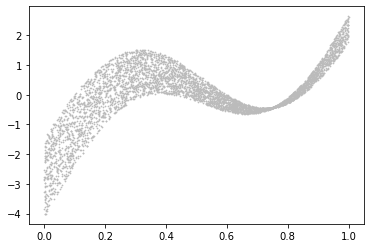

In [67]:
num_points = 5000

set_seed(40)
x = torch.rand(num_points, 1)
noise = torch.rand_like(x) * 1.
y_true = .5 * (x*6).sin() + x + (x - .75) * noise
# standardize y, just to make it well behaved.
y_true -= y_true.mean()
y_true /= y_true.std()

plot_data(x, y_true)

In [68]:
y_true.var()

tensor(1.0000)

In `006` and `009`, we dealt with models that could only ever make straight lines. They couldn't even make a curve like `3 * x**2 + 2*x + 1`, yet alone that one!

But you may remember from your math or stats studies that a curve like that is actually linear if you transform your data, e.g., using `z = [x, x**2]` as the input; then the model is `3 * z[1] + 2 * z[0] + 1`, which is linear in `z`.

So if we transform our data before giving it to the linear model, we can actually get interesting functions from a linear model. But how do we transform the data?

The classic approach is to specify what transformation to make. e.g., in *polynomial regression* we put in a bunch of powers of `x` (`x**2`, `x**3`, ..., `x**10`, ...), but that gets numerically unstable with high powers. There are other "basis functions" that are better behaved, like *splines*.

But neural nets take a different approach: they *learn* the transformation based on what is needed to accomplish its objective.

**Instructions**:

1. **Fit a line to this data** (minimizing the MSE). Evaluate the MSE. By eye, how well does it fit?
2. **Add a layer**: Use `nn.Sequential` to put two `nn.Linear` layers back to back. Use 500 dimensions as the hidden dimension (the `out_features` of the first and the `in_features` of the second). Evaluate the MSE. How well does it fit?
3. **Add a nonlinearity**: Add a `nn.ReLU` between the two linear layers. Evaluate the MSE. How well does it fit?

Details and tips are given inline below.

## Solution

**Make a `DataLoaders` for this data**. This step has been done for you. 

We increased the dataset size and the batch size to make the learning better-behaved. Once you get this to work, you might see if you can deal with a smaller batch size or less data overall.

In [69]:
splitter = RandomSplitter(valid_pct=0.2, seed=42)
batch_size = 100
dataloaders = make_dataloaders(x, y_true, splitter, batch_size=batch_size)

### Step 1: Fit a Line

**Fit a line to this data (minimizing the MSE).**

* Use a `nn.Linear` module as your `model`
* Use `Learner` with `opt_func=SGD`, as you did in `009`.
* Pass `cbs=[ShowPredictions(), ShowGraphCallback()]` to the `Learner` to show the training progress.

Tune the learning rate and number of epochs until you reliably get an MSE below 0.76.

In [103]:
from sklearn.linear_model import LinearRegression

((LinearRegression().fit(x, y_true).predict(to_np(x)) - to_np(y_true))**2).mean()

0.7543805

epoch,train_loss,valid_loss,mae,time
0,0.874187,0.832936,0.714212,00:00
1,0.813856,0.791819,0.713678,00:00
2,0.781698,0.772315,0.713267,00:00
3,0.764710,0.766033,0.715776,00:00
4,0.758373,0.762957,0.717205,00:00
5,0.758529,0.762139,0.718560,00:00
6,0.755756,0.762157,0.719628,00:00
7,0.749939,0.762317,0.720128,00:00
8,0.752072,0.761064,0.719953,00:00
9,0.754481,0.760400,0.720001,00:00


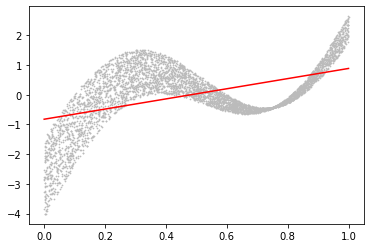

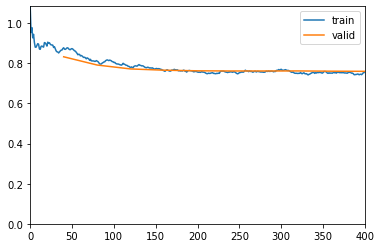

In [79]:
# # your code here <<EOF
model = nn.Linear(in_features=1, out_features=1, bias=True)
loss_func = nn.MSELoss()

learner = Learner(
    dls=dataloaders,
    model=model,
    loss_func=loss_func,
    opt_func=SGD,
    metrics=[mae],
    cbs=[ShowPredictions(), ShowGraphCallback()],
)

learner.fit(n_epoch=10, lr=1e-1)
# EOF

Evaluate the MSE. By eye, how well does it fit?

*Your narrative response here*

### Step 2: Add a Layer

**Use `nn.Sequential` to put two `nn.Linear` layers back to back.**

Use 500 dimensions as the hidden dimension (the `out_features` of the first and the `in_features` of the second).

You may notice that the training is much less stable, and is rather sensitive to initializations (run the same thing multiple times and see that it will sometimes converge much better than other times). To improve training, try the following:

* Instead of `learner.fit`, use `learner.fit_one_cycle`. This starts the learning rate low, gradually ramps it up, then ramps it back down. It also enables *momentum*, which tends to make gradient descent both faster and more stable. **Can `fit_one_cycle` handle a larger learning rate (`lr_max=XXX`) than `fit` (`lr=XXX`)?**
* Instead of `opt_func=SGD`, omit the `opt_func` parameter so it uses the default "Adam" optimizer. Adam adapts the effective learning rate for every parameter based on how big its gradients have been recently. As Sebastian Ruder [puts it](https://ruder.io/optimizing-gradient-descent/index.html#adam): "Whereas momentum can be seen as a ball running down a slope, Adam behaves like a heavy ball with friction, which thus prefers flat minima in the error surface." **Does changing to Adam have much effect here?**

epoch,train_loss,valid_loss,mae,time
0,0.884048,0.857680,0.772873,00:00
1,0.841320,0.902878,0.778506,00:00
2,0.928253,0.894079,0.776019,00:00
3,0.845945,0.794409,0.748225,00:00
4,0.817708,0.762518,0.720555,00:00
5,0.801230,0.782713,0.748406,00:00
6,0.803783,0.881031,0.748442,00:00
7,0.808957,0.764056,0.725683,00:00
8,0.800893,0.760445,0.726515,00:00
9,0.774549,0.765282,0.727754,00:00


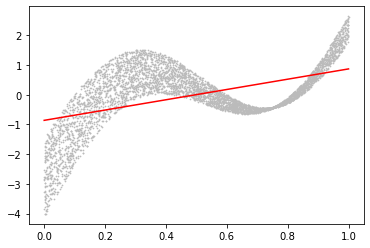

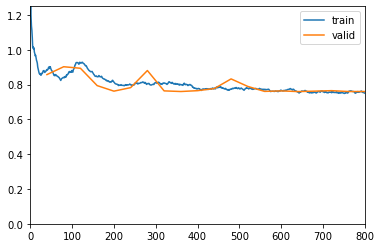

In [102]:
model = nn.Sequential(
    # ...
    nn.Linear(in_features=1, out_features=500, bias=True),
    # ...
    nn.Linear(in_features=500, out_features=1, bias=True),
)
# ... <<EOF
loss_func = nn.MSELoss()

learner = Learner(
    dls=dataloaders,
    model=model,
    loss_func=loss_func,
    #opt_func=SGD,
    metrics=[mae],
    cbs=[ShowPredictions(), ShowGraphCallback()],
)

learner.fit_one_cycle(n_epoch=20, lr_max=1e-1)
# EOF

Evaluate the MSE. By eye, how well does it fit?

*Your narrative response here*

### Step 3: **Add a nonlinearity**

Add a `nn.ReLU` between the two linear layers.

* Definitely use `fit_one_cycle` here!
* You will probably need more epochs to fit this model.
* Try several different `set_seed`s here to ensure that your results aren't a fluke.

epoch,train_loss,valid_loss,mae,time
0,0.729469,0.595133,0.609086,00:00
1,0.495646,0.239505,0.403574,00:00
2,0.324053,0.195777,0.338140,00:00
3,0.256721,0.321812,0.411051,00:00
4,0.245036,0.215227,0.349731,00:00
5,0.223740,0.185434,0.305581,00:00
6,0.211715,0.181082,0.304538,00:00
7,0.212846,0.391572,0.527217,00:00
8,0.201319,0.289575,0.377793,00:00
9,0.200701,0.174712,0.299026,00:00


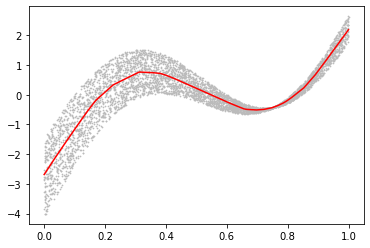

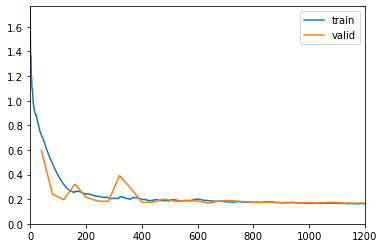

In [107]:
# set_seed(...)
set_seed(10)
# ... << EOF
model = nn.Sequential(
    nn.Linear(1, 500),
    nn.ReLU(),
    nn.Linear(500, 1)
)

learner = Learner(
    dls=dataloaders,
    model=model,
    loss_func=loss_func,
    metrics=[mae],
    cbs=[ShowPredictions(), ShowGraphCallback()]
)
learner.fit_one_cycle(n_epoch=30, lr_max=.1)
# EOF


Evaluate the MSE. How well does it fit?

*your narrative response here*

## Analysis

Despite having a hidden layer like the final model, the second model never gave us anything more than a straight line. Why not?

*your narrative response here*

Watch the model plot in Step 3 as the model fits (use at least 30 epochs to be able to watch this clearly). What do you notice about the plot during three regimes of training:

1. Within the first epoch (right at the start of training)
2. Mid-training
3. In the last epoch or two

*your narrative response here*

## Extension (optional)

What effect does the size of the hidden layer have on the quality of the fit?

What effect does the choice of nonlinearity ("activation function") have? Try a few others: `Tanh`, `Sigmoid`, `LeakyReLU`,  `PReLU`, ... Early research in neural nets used smooth functions like `Tanh` and `Sigmoid` almost exclusively; do you think the `ReLU` was a good idea?